### Machine Learning工作流程一览

- **读取数据**：从CSV文件中加载数据，确保数据的完整性和正确性。
- **数据清洗**：检查数据中的缺失值或异常值，并进行适当的处理。
- **处理游戏类型相关参数**：将游戏类型列（genres）中的数据转换为适合聚类分析的格式。具体来说将参考游戏类型占总体出现的频率，以及该游戏所包含类型的情况确定每种类型的权重。
- **构建矩阵**：创建一个矩阵，其中每行代表一个玩家，每列对应游戏类型、消费金额、游戏数量等参数。
- **数据标准化**： 将整理好的矩阵数据进行归一化。
- **降维**：应用主成分分析（PCA）来降低数据的维度，从而简化模型并提取最有信息量的特征。选择保留的成分数量应基于解释的方差比例和问题的具体需求。
- **聚类分析**：使用Kmeans聚类算法对PCA处理后的数据进行聚类。
- **展示聚类结果**：利用散点图或其他可视化工具展示Kmeans聚类的结果，每个聚类用不同的颜色或标记表示。

### 读取数据

In [192]:
import pandas as pd
import re
from ast import literal_eval # 将字符转成应有的数据类型,literal表示字面量，即原本是什么类型，eval表示评估
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
data = pd.read_csv('../../data/processed/all_steam_and_game_data_after_cleaned.csv')
data.head(5)

,Unnamed: 0,steamid,communityvisibilitystate,profilestate,personaname,profileurl,avatar,avatarmedium,avatarfull,avatarhash,...,playtime_2weeks_game3,playtime_forever_game3_2weeks,steam_appid_2weeks_game_3,price_overview_2weeks_game_3,genres_2weeks_game_3,developers_2weeks_game_3,publishers_2weeks_game_3,categories_2weeks_game_3,release_date_2weeks_game_3,metacritic_2weeks_game_3
0,0,76561197960269904,3,1,ツxxツ,https://steamcommunity.com/id/xcari/,https://avatars.steamstatic.com/c8499ee4d5ebde...,https://avatars.steamstatic.com/c8499ee4d5ebde...,https://avatars.steamstatic.com/c8499ee4d5ebde...,c8499ee4d5ebdebd78f07fc3fa19ce5370da82be,...,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,1,76561197960280448,3,1,recon,https://steamcommunity.com/id/pzrecon/,https://avatars.steamstatic.com/628974cb0fcec1...,https://avatars.steamstatic.com/628974cb0fcec1...,https://avatars.steamstatic.com/628974cb0fcec1...,628974cb0fcec15a07cd1601fdadc7aa44ac245d,...,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,2,76561197960290464,3,1,JKBe,https://steamcommunity.com/profiles/7656119796...,https://avatars.steamstatic.com/c698ae39dd85c1...,https://avatars.steamstatic.com/c698ae39dd85c1...,https://avatars.steamstatic.com/c698ae39dd85c1...,c698ae39dd85c1a1567e184a4b1735e9077a475f,...,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
3,3,76561197960315952,3,1,chuNami5000,https://steamcommunity.com/id/chuNk--/,https://avatars.steamstatic.com/b16314c3aff86b...,https://avatars.steamstatic.com/b16314c3aff86b...,https://avatars.steamstatic.com/b16314c3aff86b...,b16314c3aff86bf70b0bb5e54570fe8aa3efdd5d,...,67,272,952060,40,['Action'],"['CAPCOMCo.,Ltd.']","['CAPCOMCo.,Ltd.']","['Single-player', 'Multi-player', 'PvP', 'Onli...","2Apr,2020",77
4,4,76561197960331200,3,1,Mikki,https://steamcommunity.com/profiles/7656119796...,https://avatars.steamstatic.com/fef49e7fa7e199...,https://avatars.steamstatic.com/fef49e7fa7e199...,https://avatars.steamstatic.com/fef49e7fa7e199...,fef49e7fa7e1997310d705b2a6158ff8dc1cdfeb,...,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


### 数据清洗

In [194]:
'''默认值处理以及数据类型转换'''

# 替换unknown为空值na
data.replace('Unknown', pd.NA, inplace=True)

for idx, col in enumerate(data.columns):
    # 这里的r是原始字符串，不是read
    if re.search(r'genres', col):
        data[col] = data[col].apply(lambda x: literal_eval(x) if pd.notna(x) else x)
    else:
        pass

### 处理游戏类型相关参数

In [195]:
'''整合数据至一列'''

all_genres = pd.Series(dtype='object')

for column in data:
    if re.search(r'genres', column):
        non_na_series = data[column].dropna()
        all_genres = pd.concat([all_genres, non_na_series], ignore_index=True)

# 现在 all_genres 中的每个元素都应该是列表类型
all_genres

0                                     [Action, FreetoPlay]
1                                     [Action, FreetoPlay]
2                          [Action, Indie, Racing, Sports]
3                                                 [Action]
4        [Action, Adventure, Indie, MassivelyMultiplaye...
                               ...                        
33182                                             [Action]
33183                                 [Action, FreetoPlay]
33184                                             [Action]
33185                                             [Action]
33186                                 [Action, FreetoPlay]
Length: 33187, dtype: object

In [196]:
'''统计类型出现次数'''
genre_counts = {}
for genre_list in all_genres:
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

'''剔除极端键值影响'''
need_genre_counts = ['Nudity', 'Gore', 'Violent', 'Экшены', 'Приключенческиеигры', 'Инди', 'Стратегии','Казуальныеигры', 'Гонки', 'Симуляторы','Utilities', 'Animation&Modeling', 'Design&Illustration', 'GameDevelopment', 'EarlyAccess', 'PhotoEditing', 'AudioProduction', 'VideoProduction', 'Education', 'WebPublishing', 'SoftwareTraining']

for key in need_genre_counts:
    if key in genre_counts:
        del genre_counts[key]
        

pd.Series(genre_counts).to_csv('./data/genre_count.csv')
genre_counts

{'Action': 24055,
 'FreetoPlay': 11575,
 'Indie': 9360,
 'Racing': 1294,
 'Sports': 1924,
 'Adventure': 10562,
 'MassivelyMultiplayer': 6275,
 'RPG': 7395,
 'Simulation': 5816,
 'Strategy': 5286,
 'Casual': 3549}

加权方式介绍
- **计算类别权重**：
   - **计算比例倒数**：首先计算每个游戏类别在总类别中的占比，然后取该占比的倒数。
   - **归一化权重**：将各类别的倒数权重除以所有倒数权重的总和，确保权重总和为1。

- **计算加权时间**：
   - 根据归一化的倒数权重，为每个玩家所玩游戏的时间进行加权分配。

假设玩家A玩《荒野大镖客》200分钟，游戏类型包括[Action, Adventure]：

- **权重计算**：
  - Action的原始权重：1/24051
  - Adventure的原始权重：1/10559
  - 归一化后的权重：计算上述两者的权重总和，然后各自除以该总和。

- **加权时间计算**：
  - 使用归一化后的权重乘以200分钟，得到分配给Action和Adventure类别的加权游戏时间。

通过此方法可以更公平地评估玩家对各种不同流行程度游戏类别的参与度。


In [197]:
'''从原始数据中提取需要的列，并重命名方便使用'''
for_game_cluster_columns = []
for col in data:
    if re.search('steamid|genres|playtime_forever_game',col):
        for_game_cluster_columns.append(col) 
for_game_cluster_df = data[for_game_cluster_columns]
for_game_cluster_df.columns= ['steamid', 'playtime_game1', 'genres1',
       'playtime_game2', 'genres2', 'playtime_game3',
       'genres3', 'playtime_game4', 'genres4',
       'playtime_game5', 'genres5', 'playtime_game6',
       'genres6', 'playtime_game7',
       'genres7', 'playtime_game8',
       'genres8']

计算每个游戏种类的加权时间

In [198]:
'''定义加权函数'''

# 定义加权函数
def calculate_weighted_playtime(row, genre_index):
    genre_col = f'genres{genre_index}' # 以后缀的形式检索本轮循环需要后续处理的列
    playtime_col = f'playtime_game{genre_index}' 

    genres = row[genre_col]
    playtime = row.get(playtime_col, 0)
    
    # if genres is pd.isna(genres):  # 检查是否为NaN
    #     return None
        
    if not isinstance(genres, list):  # 确保 genres 是一个列表
        return None
    
    total_count = sum(genre_counts.get(genre, 0) for genre in genres if genre in genre_counts) # 计算单一用户单一游戏（例如用户A：游戏：荒野大镖客），游戏所包含种类在总体出现的次数（例如荒野大镖客包含动作类、冒险类，动作类冒险类分别在所有游戏出现次数1万次和5千次，因此总计1.5w次），用于后续计算权重
    weighted_product_dict = {}
    
    if total_count > 0:
        genre_weights = {}
        total_weight = 0

        # 计算每个genre的权重并累加总权重
        for genre in genres:
            if genre in genre_counts:
                genre_weight = 1 / (genre_counts[genre] / total_count) # 该类别次数占总体次数的倒数作为权重
                genre_weights[genre] = genre_weight
                total_weight += genre_weight #总体权重用于后续归一化

        # 归一化权重并计算加权产品
        for genre, genre_weight in genre_weights.items():
            normalized_genre_weight = genre_weight / total_weight
            weighted_product_dict[genre] = normalized_genre_weight * playtime # 归一后的时间

    
    return weighted_product_dict


先计算前1至5游玩时间总计最长的游戏

In [199]:
# 应用函数到每行的 genres 和 playtime 列
for i in range(1,9):  # 根据你的 DataFrame 实际列数调整
    for_game_cluster_df[f'weighted_playtime{i}'] = for_game_cluster_df.apply(lambda row: calculate_weighted_playtime(row, i), axis=1)


C:\Users\55386\AppData\Local\Temp\ipykernel_15996\3749882382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_game_cluster_df[f'weighted_playtime{i}'] = for_game_cluster_df.apply(lambda row: calculate_weighted_playtime(row, i), axis=1)
C:\Users\55386\AppData\Local\Temp\ipykernel_15996\3749882382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_game_cluster_df[f'weighted_playtime{i}'] = for_game_cluster_df.apply(lambda row: calculate_weighted_playtime(row, i), axis=1)
C:\Users\55386\AppData\Loc

In [200]:
# 定义合并字典的函数
def merge_weighted_playtimes(row):
    result = {}
    # 循环每个加权时间列
    for i in range(1,9):  # 根据实际列数调整
        playtime_dict = row[f'weighted_playtime{i}']
        if playtime_dict is not None:
            for genre, time in playtime_dict.items():
                if genre in result:
                    result[genre] += time
                else:
                    result[genre] = time
    return result

In [201]:
# 应用合并函数并创建一个新列
for_game_cluster_df['weighted_playtime'] = for_game_cluster_df.apply(merge_weighted_playtimes, axis=1)
for_game_cluster_df

C:\Users\55386\AppData\Local\Temp\ipykernel_15996\1625308751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_game_cluster_df['weighted_playtime'] = for_game_cluster_df.apply(merge_weighted_playtimes, axis=1)


,steamid,playtime_game1,genres1,playtime_game2,genres2,playtime_game3,genres3,playtime_game4,genres4,playtime_game5,...,genres8,weighted_playtime1,weighted_playtime2,weighted_playtime3,weighted_playtime4,weighted_playtime5,weighted_playtime6,weighted_playtime7,weighted_playtime8,weighted_playtime
0,76561197960269904,0,<NA>,0,<NA>,0,<NA>,0,<NA>,0,...,<NA>,None,None,None,None,None,None,None,None,{}
1,76561197960280448,0,<NA>,0,<NA>,0,<NA>,0,<NA>,0,...,<NA>,None,None,None,None,None,None,None,None,{}
2,76561197960290464,0,<NA>,0,<NA>,0,<NA>,0,<NA>,0,...,<NA>,None,None,None,None,None,None,None,None,{}
3,76561197960315952,371092,"[Action, FreetoPlay]",50721,[Action],4951,[Action],3903,"[Action, Adventure]",3742,...,[Action],"{'Action': 120555.42801010383, 'FreetoPlay': 2...",{'Action': 50721.0},{'Action': 4951.0},"{'Action': 1190.8451338937516, 'Adventure': 27...","{'Action': 96.44770865584739, 'Indie': 247.868...","{'Action': 120555.42801010383, 'FreetoPlay': 2...","{'Action': 26.63906820095425, 'FreetoPlay': 55...",{'Action': 272.0},"{'Action': 298368.7879309582, 'FreetoPlay': 50..."
4,76561197960331200,0,<NA>,0,<NA>,0,<NA>,0,<NA>,0,...,<NA>,None,None,None,None,None,None,None,None,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20436,76561198156455808,0,NaN,0,NaN,0,NaN,0,NaN,0,...,<NA>,None,None,None,None,None,None,None,None,{}
20437,76561198130132224,0,NaN,0,NaN,0,NaN,0,NaN,0,...,<NA>,None,None,None,None,None,"{'Simulation': 6558.006201550387, 'Sports': 19...","{'Action': 10621.974001386474, 'Adventure': 24...",None,"{'Simulation': 6558.006201550387, 'Sports': 19..."
20438,76561198981187936,0,NaN,0,NaN,0,NaN,0,NaN,0,...,<NA>,None,None,None,None,None,None,None,None,{}
20439,76561198106511888,0,NaN,0,NaN,0,NaN,0,NaN,0,...,[Action],None,None,None,None,None,"{'Action': 1464.4216216216216, 'RPG': 4763.578...",{'Action': 7962.0},{'Action': 6860.0},"{'Action': 16286.421621621621, 'RPG': 4763.578..."


### 构建矩阵

构建有关`种类权重游玩时间`的矩阵用于后续PCA参数

In [202]:
player_weighted_playtime_df = for_game_cluster_df[for_game_cluster_df['weighted_playtime']!={}][['steamid','weighted_playtime']] # 筛选不为空字典的用户
genre_playtime_df = player_weighted_playtime_df['weighted_playtime'].apply(pd.Series) # apply将这一列中所有字典传递给pd.series
# 给每列添加后缀
suffix = '_weighted_playtime (in_minutes)'
columns_name = []
for col in genre_playtime_df.columns:
    col = f'{col}{suffix}'
    columns_name.append(col)
genre_playtime_df.columns = columns_name

player_weighted_playtime_df = pd.concat([player_weighted_playtime_df['steamid'],genre_playtime_df],axis=1)

In [203]:
player_weighted_playtime_df

,steamid,Action_weighted_playtime (in_minutes),FreetoPlay_weighted_playtime (in_minutes),Adventure_weighted_playtime (in_minutes),Indie_weighted_playtime (in_minutes),Racing_weighted_playtime (in_minutes),Simulation_weighted_playtime (in_minutes),Sports_weighted_playtime (in_minutes),MassivelyMultiplayer_weighted_playtime (in_minutes),RPG_weighted_playtime (in_minutes),Strategy_weighted_playtime (in_minutes),Casual_weighted_playtime (in_minutes)
3,76561197960315952,298368.787931,501128.504912,2712.154866,247.868550,1792.928618,398.908121,1205.847002,NaN,NaN,NaN,NaN
7,76561197960402768,252506.232341,293494.342890,7209.867579,NaN,NaN,NaN,NaN,12135.557190,10037.605867,14042.394133,NaN
10,76561197960695552,16230.938793,NaN,34492.739699,7139.907614,20187.724861,145.924850,13577.399153,NaN,22732.196166,NaN,9773.168864
11,76561197960790464,112491.951633,184771.835813,6226.212555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,76561197960975680,95139.339147,40178.722286,21235.242866,20744.307984,NaN,NaN,NaN,35742.890063,30329.497654,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20424,76561198064762336,2837.049840,3971.809290,NaN,2379.438182,NaN,NaN,NaN,NaN,3011.702688,NaN,NaN
20433,76561198073896624,2167.208618,NaN,112.073066,394.279278,NaN,203.527464,NaN,NaN,338.977459,223.934114,NaN
20437,76561198130132224,10621.974001,22074.434955,24191.591044,NaN,NaN,6558.006202,19823.993798,NaN,NaN,NaN,NaN
20439,76561198106511888,16286.421622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4763.578378,NaN,NaN


构建有关`价格`的矩阵用于后续PCA

In [204]:
price_df = data[['steamid']+[col for col in data.columns if re.search(r'price', col)]]
price_columns = [col for col in price_df.columns if re.search(r'price',col)]
price_df['total_price(dollar)'] = price_df.apply(lambda row: row[price_columns].sum(), axis = 1)
price_df = price_df[['steamid', 'total_price(dollar)']]
price_df

C:\Users\55386\AppData\Local\Temp\ipykernel_15996\2877274029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['total_price(dollar)'] = price_df.apply(lambda row: row[price_columns].sum(), axis = 1)


,steamid,total_price(dollar)
0,76561197960269904,0
1,76561197960280448,0
2,76561197960290464,0
3,76561197960315952,145
4,76561197960331200,0
...,...,...
20436,76561198156455808,0
20437,76561198130132224,0
20438,76561198981187936,0
20439,76561198106511888,101


矩阵合并

In [205]:
merged_df = pd.merge(left = player_weighted_playtime_df, right = price_df, how = 'left', left_on = 'steamid', right_on= 'steamid')


In [206]:
merged_df.head()

,steamid,Action_weighted_playtime (in_minutes),FreetoPlay_weighted_playtime (in_minutes),Adventure_weighted_playtime (in_minutes),Indie_weighted_playtime (in_minutes),Racing_weighted_playtime (in_minutes),Simulation_weighted_playtime (in_minutes),Sports_weighted_playtime (in_minutes),MassivelyMultiplayer_weighted_playtime (in_minutes),RPG_weighted_playtime (in_minutes),Strategy_weighted_playtime (in_minutes),Casual_weighted_playtime (in_minutes),total_price(dollar)
0,76561197960315952,298368.787931,501128.504912,2712.154866,247.868550,1792.928618,398.908121,1205.847002,NaN,NaN,NaN,NaN,145
1,76561197960402768,252506.232341,293494.342890,7209.867579,NaN,NaN,NaN,NaN,12135.557190,10037.605867,14042.394133,NaN,23
2,76561197960695552,16230.938793,NaN,34492.739699,7139.907614,20187.724861,145.924850,13577.399153,NaN,22732.196166,NaN,9773.168864,174
3,76561197960790464,112491.951633,184771.835813,6226.212555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
4,76561197960975680,95139.339147,40178.722286,21235.242866,20744.307984,NaN,NaN,NaN,35742.890063,30329.497654,NaN,NaN,48


### 数据标准化

将每列特征以其均值作为中心点，每个单元格x-μ，再除以标准差σ 

In [207]:
# 填补空缺值
merged_df.fillna(0,inplace=True)

playtime_columns = [col for col in merged_df.columns if re.search(r'playtime|price', col)]
data = merged_df[playtime_columns]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled)
data_scaled_df.columns = data.columns

In [208]:
data_scaled_df

,Action_weighted_playtime (in_minutes),FreetoPlay_weighted_playtime (in_minutes),Adventure_weighted_playtime (in_minutes),Indie_weighted_playtime (in_minutes),Racing_weighted_playtime (in_minutes),Simulation_weighted_playtime (in_minutes),Sports_weighted_playtime (in_minutes),MassivelyMultiplayer_weighted_playtime (in_minutes),RPG_weighted_playtime (in_minutes),Strategy_weighted_playtime (in_minutes),Casual_weighted_playtime (in_minutes),total_price(dollar)
0,2.347370,2.958654,-0.370573,-0.305744,-0.119110,-0.307166,-0.180359,-0.365808,-0.367527,-0.336563,-0.183984,1.312797
1,1.875834,1.469039,-0.244359,-0.310424,-0.184925,-0.318023,-0.235200,-0.113851,-0.130312,-0.072522,-0.183984,-0.781549
2,-0.553432,-0.636556,0.521246,-0.175605,0.556129,-0.314052,0.382284,-0.365808,0.169693,-0.336563,0.018673,1.810633
3,0.436276,0.689039,-0.271963,-0.310424,-0.184925,-0.318023,-0.235200,-0.365808,-0.367527,-0.336563,-0.183984,-0.112045
4,0.257865,-0.348304,0.149217,0.081279,-0.184925,-0.318023,-0.235200,0.376282,0.349237,-0.336563,-0.183984,-0.352380
...,...,...,...,...,...,...,...,...,...,...,...,...
5875,-0.691141,-0.608061,-0.446681,-0.265495,-0.184925,-0.318023,-0.235200,-0.365808,-0.296353,-0.336563,-0.183984,-0.300880
5876,-0.698028,-0.636556,-0.443536,-0.302979,-0.184925,-0.312484,-0.235200,-0.365808,-0.359516,-0.332352,-0.183984,0.145456
5877,-0.611100,-0.478189,0.232178,-0.310424,-0.184925,-0.139531,0.666371,-0.365808,-0.367527,-0.336563,-0.183984,-1.176385
5878,-0.552861,-0.636556,-0.446681,-0.310424,-0.184925,-0.318023,-0.235200,-0.365808,-0.254951,-0.336563,-0.183984,0.557459


### 降维-PCA技术

累积方差解释率： [0.21627423 0.37446268 0.51937765 0.63453722 0.72748296 0.8031065
 0.85549026 0.90623853 0.93882195 0.96047912 0.98184988 1.        ]


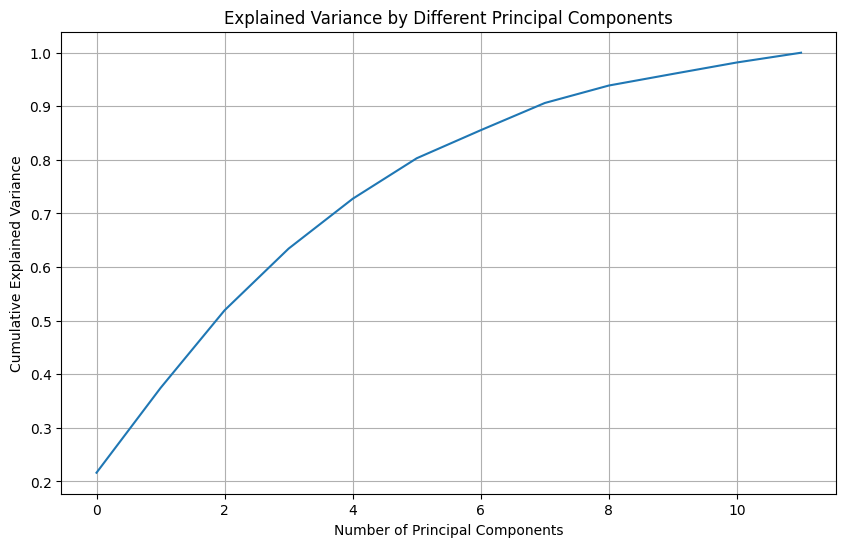

In [209]:
# 创建PCA实例，不限制主成分数量
pca_full = PCA()

# 拟合数据
pca_full.fit(data_scaled)

# 打印累积方差解释率
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
print("累积方差解释率：", cumulative_variance_ratio)

# 绘制方差解释率图


plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.grid(True)
plt.show()


结果显示3个维度已有较高的拟合程度（约63.4%）

In [210]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)  # 根据需要选择适当的主成分数量
principalComponents = pca.fit_transform(data_scaled)  # data_scaled是你的原始数据集
pca_df = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2','Principal Component 3'])

# 载荷量
loadings = pca.components_.T  # .T 是为了转置，以便于每行代表一个变量，每列代表一个主成分

# 创建一个新的DataFrame来查看载荷量，列为每个主成分，行为原始特征
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=data_scaled_df.columns)
display(loadings_df) # 每个主成分的组成
display(pca_df) # 每个用户的分布情况

,PC1,PC2,PC3
Action_weighted_playtime (in_minutes),0.196746,-0.568458,-0.015092
FreetoPlay_weighted_playtime (in_minutes),0.126139,-0.590838,-0.022111
Adventure_weighted_playtime (in_minutes),0.418835,-0.154556,-0.064379
Indie_weighted_playtime (in_minutes),0.324197,0.207383,0.047272
Racing_weighted_playtime (in_minutes),0.044060,-0.062235,0.694772
Simulation_weighted_playtime (in_minutes),0.311741,0.298932,0.061516
Sports_weighted_playtime (in_minutes),0.059236,-0.054557,0.697681
MassivelyMultiplayer_weighted_playtime (in_minutes),0.450874,-0.149591,-0.092346
RPG_weighted_playtime (in_minutes),0.448044,0.038767,-0.098894
Strategy_weighted_playtime (in_minutes),0.202057,0.143586,0.002401


,Principal Component 1,Principal Component 2,Principal Component 3
0,0.269893,-2.917473,-0.245029
1,-0.095839,-2.257253,-0.361820
2,0.115759,0.857811,0.646546
3,-0.634348,-0.829547,-0.269304
4,0.112912,-0.237480,-0.393723
...,...,...,...
5875,-1.082576,0.573453,-0.218875
5876,-1.038814,0.688207,-0.209736
5877,-0.870782,0.137430,0.370825
5878,-0.891002,0.700991,-0.219276


可以看到每个主成分中各自由什么组成

### 聚类分析-Kmeans

c:\Users\55386\anaconda3\envs\Zeyu_for_data_analyze_use\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\55386\anaconda3\envs\Zeyu_for_data_analyze_use\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\55386\anaconda3\envs\Zeyu_for_data_analyze_use\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\55386\anaconda3\envs\Zeyu_for_data_analyze_use\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

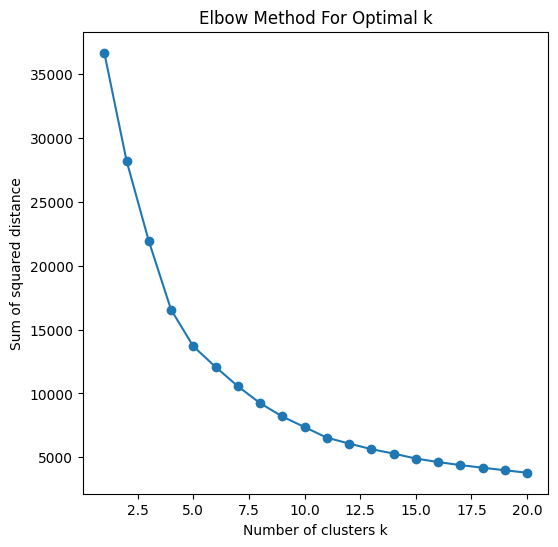

In [211]:
from sklearn.cluster import KMeans

# 计算不同K值的SSE
sse = []
list_k = list(range(1, 21))  # 测试20个聚类
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(pca_df[['Principal Component 1', 'Principal Component 2', 'Principal Component 3']])
    sse.append(km.inertia_)

# 绘制SSE曲线
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal k')
plt.show()


经图像分析，经过elbow原则判断，选择6个分类似乎是可行点

c:\Users\55386\anaconda3\envs\Zeyu_for_data_analyze_use\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


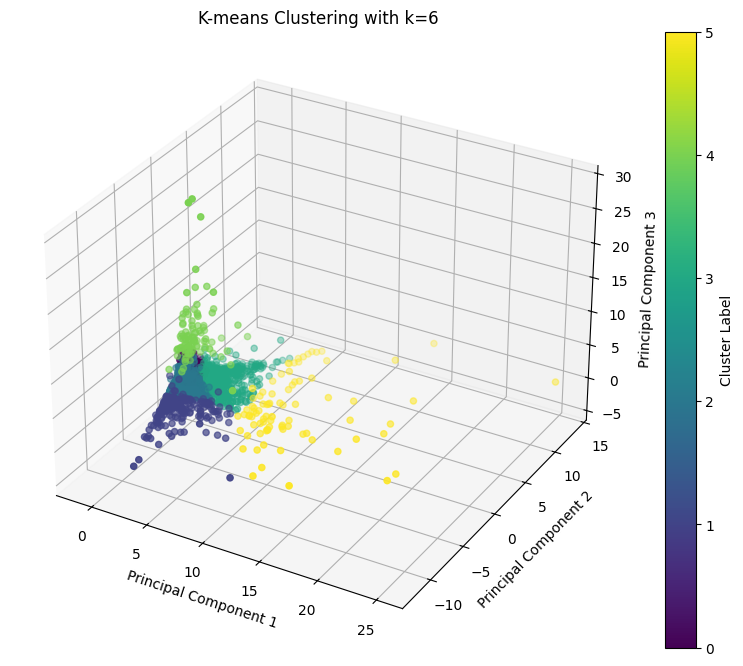

In [212]:

# 假设 kmeans 已经被定义并且已经对 pca_df 进行了聚类预测
k = 6
kmeans = KMeans(n_clusters=k, random_state=40, max_iter=1000) # 设置40的seed，最大迭代次数为1000次
labels = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2', 'Principal Component 3']])

# 创建一个新的图和一个3d子图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
scatter = ax.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], pca_df['Principal Component 3'], c=labels, cmap='viridis')

# 设置图的标签和标题
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title(f'K-means Clustering with k={k}')

# 添加颜色条
color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label('Cluster Label')

# 显示图形
plt.show()


In [213]:
pca_df['Cluster_Labels'] = labels # 添加分组信息至表格

### 合并数据分析

In [214]:
steam_user_cluster_df = pd.concat([merged_df,pca_df],axis=1)
steam_user_cluster_df.to_csv('./data/steam_user_cluster.csv')

之后的分析使用excel透视图

In [215]:
data = pd.read_csv('./data/cluster_analysis_for_hot_map.csv')
data = data[data['Group_label']!= 'total'] # 剔除总计项
data.set_index('Group_label',inplace=True)
# 计算每列的排名，用于颜色映射
sorted_data = data.rank(method='min')

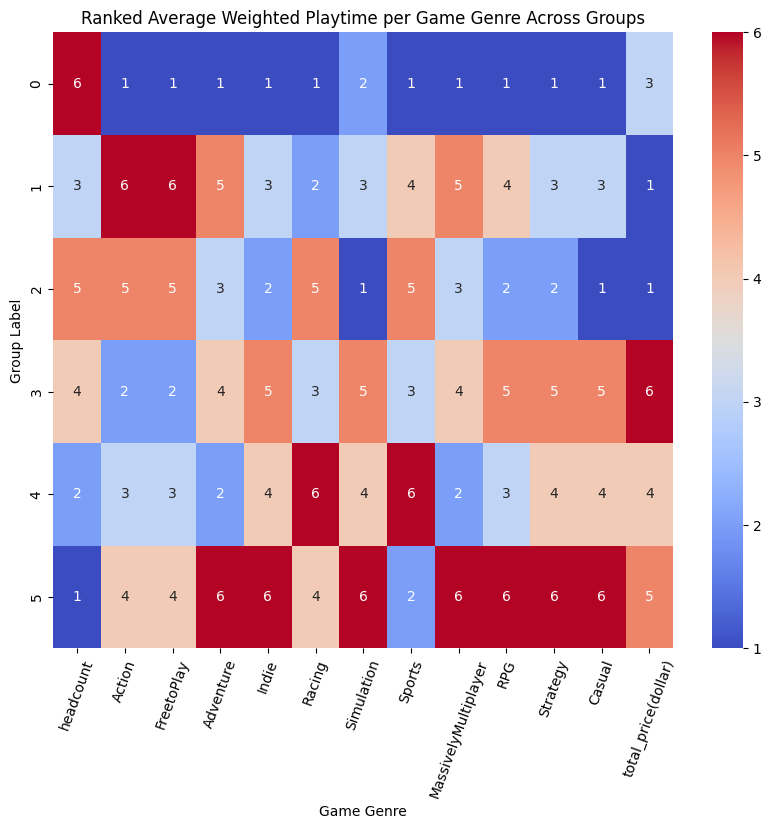

In [218]:
plt.figure(figsize=(10, 8))  # 调整图像尺寸
sns.heatmap(sorted_data, annot=True, cmap='coolwarm', )  # 调整注释字体大小和颜色
plt.title('Ranked Average Weighted Playtime per Game Genre Across Groups')
plt.xlabel('Game Genre')
plt.ylabel('Group Label')
plt.xticks(rotation = 70)
plt.show()
